In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We will need ``sparse`` library

In [4]:
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve

# Heat equation in 1D with variable conductivity and grid size

In this example we will examine lateral distribution of deformation around cooling intrusion in ambient temperature. We will introduce new type of boundary condition called symmetrical boundary. It is used for problems which have by definition symmetrical solution, so it is enough to calculate only half of the domain.

<img src="https://github.com/ondrolexa/heat/raw/master/images/symmetryBC.png" alt="Domain symmetry" width="600" align="center"/>

As $T_L = T_R$, there is no thermal gradient and therefore no heat flux accross symmetry boundary. It means that boundary condition is identical to no heat flux i.e. zero Neumann BC.

The width of simulated halfdomain is 20 km (keep in mind that due to symmetry, the width of intrusion in calculation will be only half of the real width). In this model, we will not calculate initial conditions as a result of steady-state solution, but we will prescribe it. Imagine, that we will simulate situation in depth where for steady-state temperature is 350°C. So, before intrusion, temperature is constant in all calculated domain. We instantaneously emplace vertical pluton (or dyke) with thickness 1500 m and temperature 800°C.

<img src="https://github.com/ondrolexa/heat/raw/master/images/intrusion.png" alt="Domain symmetry" width="600" align="center"/>

We will use in our model temperature-dependent thermal properties (*Nabelek, 2010*):
thermal diffusivity:

$$\kappa(T)=1.214\cdot 10^{-6}\times \exp \left ( \frac{-T}{285.2} \right )+3.19\cdot 10^{-7}$$

Heat capacity (*Whittington, 2009*):

$$c(T)=726+1.53\times T-1.6\cdot 10^{-3}\times T^2+6.64\cdot 10^{-7}\times T^3$$

Thermal conductivity:

$$\lambda(T)=\rho \cdot c(T) \cdot \kappa(T)$$

where for density $\rho$ we will use value 2750 $kgm^{-3}$. We will use zero heat production in this model (it has no impact on short timed models).

### Deformation of the domain

Both intrusion and host-rock will be deformed during cooling under constant differential stress $\sigma_D$ = 20 MPa. For the dislocation creep of a polycrystal aggregate, the traditional ﬂow law (referred to as ﬂow law 1 below) is:

$$\dot\epsilon = \sigma_D^n\cdot A\cdot\exp\left(\frac{-Q}{R\cdot(T + 273.15)}\right)$$

where $\dot\epsilon$ is the strain rate, $A$ the preexponential parameter, $Q$ the activation energy, $R$ the universal gas constant, $T$ the temperature in degrees, $\sigma_D$ the differential stress (in MPa), and $n$ the stress exponent. The parameters ($A$, $Q$ and $n$) for intrusion and host-rock are listed in following table:

| Rock      | preexponential parameter A<br>[$Mpa^{-n}$] | activation energy Q<br>[$J/Mol$] | stress exponent n  |
|-----------|--------------------------------------------|----------------------------------|--------------------|
| Intrusion | $3.89\cdot 10^{-13}$                       | $68000$                          | $2$                |
| host-rock | $3.981\cdot 10^{-11}$                      | $115000$                         | $4$                |

For any given time step the incremental stretching of grid cell is:

$$ S_{i} = \exp(-\dot\epsilon\cdot\Delta t)$$

**Your task is to create model, which solve cooling of the dyke domain with simultaneous contractional deformation for 1 Ma. The model should also calculate finite (accumulated) deformation for each grid cell (variable to store finite strain will have same size as material properties).**

  1. You should plot distribution of deformation expressed as natural deformation i.e. natural logarithm of finite stretch versus position for intrusion and for host-rock.
  2. What will be final width of the intrusion?
  3. What will be final width of the domain?

The finite stretch is product of incremental stretches:

$$S = \prod_{i=1}^{n}S_i$$

and natural deformation is:

$$\varepsilon = \ln(S)$$

In [5]:
# Model definition
Ta = 350                                # ambient temperature
Ti = 800                                # intrusion temperature
model_width = 20000                     # width of the model
intrusion_width = 1500                  # width of the intrusion
n = 351                                 # number of nodes
x = linspace(0, model_width, n)         # calculation grid positions
xm = (x[1:] + x[:-1])/2                 # material grid positions
mask_i = xm <= intrusion_width / 2      # logical index for intrusion
mask_h = xm > intrusion_width / 2       # logical index for host-rock

# Deformation parameters for host-rock.

rA = 3.981e-11 * ones_like(xm)
rQ = 115000 * ones_like(xm)
rn = 4 * ones_like(xm)

# Deformation parameters for intrusion.
rA[mask_i] = 3.89e-13
rQ[mask_i] = 68000
rn[mask_i] = 2

R = 8.31446261815324                    # universal gas constant
sig = 20                                # differential stress

# Helpers functions.

# Temperature-dependent strain rate.
edot_fun = lambda T: sig ** rn * rA * exp(-rQ / (R * (T + 273.15)))

# temperature-dependent thermal properties
rho_fun = lambda T: ones_like(T) * 2750
kappa_fun = lambda T: 1.214e-6 * exp(-T / 285.2) + 3.19e-7
c_fun = lambda T: 726 + 1.53 * T - 1.6e-3 * T**2 + 6.64e-7 * T**3
k_fun = lambda T: rho_fun(T) * c_fun(T) * kappa_fun(T)

In [6]:
# Initial state

# Temperature
T = Ta * ones_like(x)
T[x <= intrusion_width / 2] = Ti

# Material properties (temperature-dependent)
Tm = interp(xm, x, T)     # temperature at material nodes
k = k_fun(Tm)
c = c_fun(Tm)
rho = rho_fun(Tm)
dx = diff(x)

# Stretch (S=1 for no deformation)
S = ones_like(xm)
ysec = 365.25*24*3600   # one year in seconds
dt = 100*ysec           # time step of hundred years

Now we need to create simulation. For each timestep we need:

  1. calculate strain rate for each cell (note different parameters for intrusion and host-rock)
  2. calculate incremental stretch for each cell for given timestep
  2. change dx based on incremental stretch and add incremental stretch to finite one
  3. relaxing temperature using evolutionary heat equation for given timestep
  4. recalculate node positions, material positions and thermal properties (conductivity, specific heat, not needed for density as it is still constant)

This should be repeated 10000 times to reach 1 Ma.

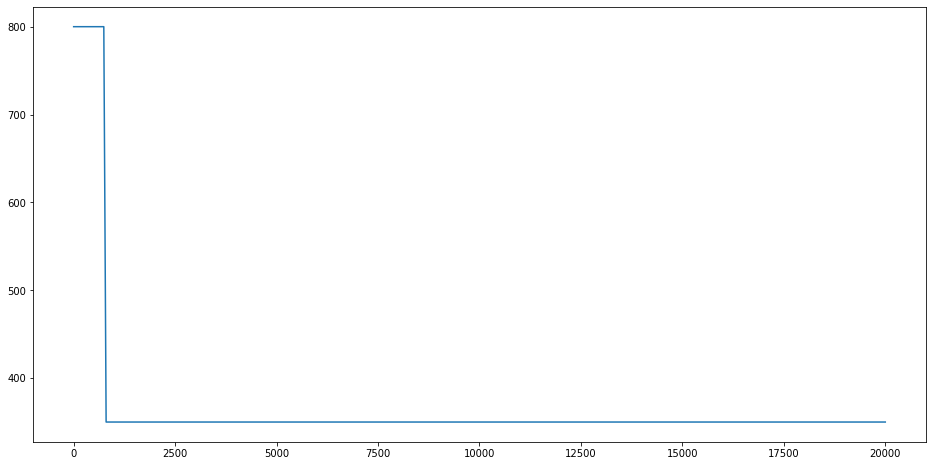

In [7]:
SS = []

figure(figsize=(16, 8))
plot(x, T);

In [8]:
for i in range(10_000):
    edot = edot_fun(Tm)
    Si = exp(-edot * dt)
    S *= Si

    SS.append(edot)
    
    # Deformation affecting node spacing.
    dx = dx * Si

    # Tempetature evolution with BTCS and `dt`.
    kl, kr = k[:-1], k[1:]
    dxl, dxr = dx[:-1], dx[1:]
    rl, rr = rho[:-1], rho[1:]
    cl, cr = c[:-1], c[1:]

    # Helpers
    alfa = kl * (1 + dxr / dxl)
    beta = kr * (1 + dxl / dxr)
    gama = (cl * rl * dxr**2 + dxl * dxr * (cl * rr + cr * rl) +  cr * rr * dxl**2) / (2 * dt)

    # Matrix with boundary conditions
    gamma_BC = c[0] * rho[0] * dx[0]**2 / dt
    dl = np.hstack((-alfa, 0, 0))
    dm = np.hstack((gamma_BC + 2 * k[0], alfa + beta + gama, 1))
    dr = np.hstack((0, -2*k[0], -beta))


    A = spdiags([dl, dm, dr], [-1, 0, 1], n, n, "csr")
    b = hstack((gamma_BC, gama, 1)) * T
    b[-1] = Ta

    T = spsolve(A, b)

    # Update node positions.
    x = hstack( (0, cumsum(dx)) )
    xm = (x[1:] + x[:-1]) / 2

    Tm = interp(xm, x, T)
    k = k_fun(Tm)
    c = c_fun(Tm)
    rho = rho_fun(Tm)

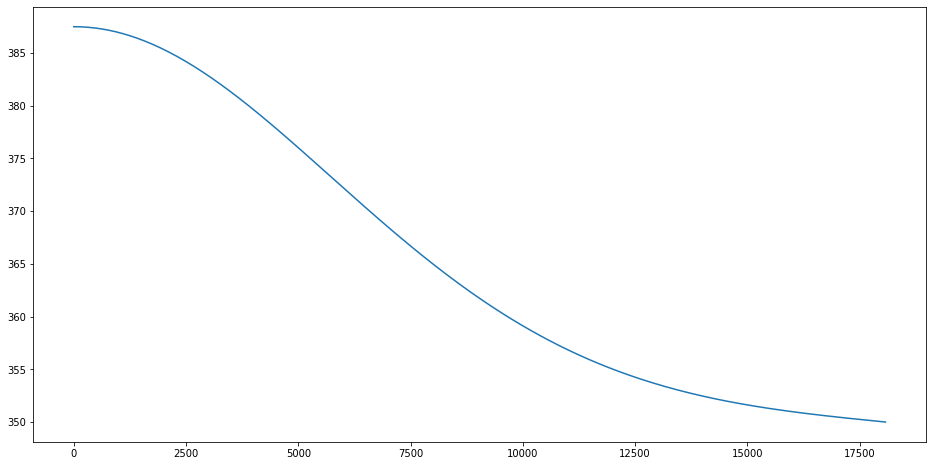

In [9]:
figure(figsize=(16, 8))
plot(x, T);

In [10]:
# e = log(S)
# Domain length
Ld_final = len(x) * abs(x[0] - x[1])
print(f"Konečná délka domény je {(Ld_final/1000)} km")


Konečná délka domény je 18.459488784379324 km


In [11]:
# Intrusion length
L = 20_000 # km
elong = (Ld_final / L) - 1 
S = elong + 1
Li =  1500 * S
print(f"Konečná délka intruze je {(Li/1000)} km")

Konečná délka intruze je 1.3844616588284493 km


In [18]:
# Graf opravdu nevím.